# 1.4 Finite Difference Method - Simple Room

Prepared by (C) Vasken Dermardiros

Let's step it up a little. Let's model a simple room with a window using 3 thermal nodes: the window, the room air and a node representing all the interior walls combined. For a more detailed analysis, the walls can be separated and the floor can be further discretized.

## Problem Statement
A small room with a 9 m<sup>2</sup> window is to be simulated. In fact, the whole wall is a window! (Ridiculous!)
All the interior surfaces of the room are lumped together and behave like a 100 mm thick 9 m<sup>2</sup> concrete slab. The air is assumed to have no thermal capacitance. The material properties are given in the script.

The exterior temperature follows a sine with mean -15°C, amplitude 5°C peaking at 15:00.

Just for fun, 500 W of heat is supplied as a pulse from 6:00 to 12:00.

------------
## FDM Implementation
### Load Dependencies

In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
# Plot in notebook; comment out the line below for windowed plots
%matplotlib inline
# mpl.rc('figure', figsize=(10, 10))
# import seaborn; seaborn.set() # Optional package: makes prettier plots

### Variable Names
Uin: Conductance matrix input by user, upper triangle only, (nN x nN) (W/K)  
U: Conductance matrix (symmetrical) with added capacitance for diagonal term, (nN x nN) (W/K)  
C: Capacitance vector, (nN x 1) (J/K)  
F: Conductance matrix of nodes connected to a known temperature source, (nN x nM) (W/K)  
T: Temperature vector per timestep, (nT x nN) (degC)  
TK: Temperature vector of known temperatures per timestep, (nT x nM) (degC)  
Qin: Heat flow, only external sources, (nN x 1) (W)  
Q: Heat flow vector + external sources + capacitance from previous timestep (implicit only), (nN x 1) (W)  
  
nN: Number of nodes  
nM: Number of nodes with known temperatures  
nT: Number of timesteps  

Node Number: Object  
0: window's interior surface, 9 m^2  
1: room air  
2: mass, 100 mm concrete, 9 m^2  
*Note that indexing starts at "0" in Python (unlike "1" in Matlab) 
  
Node Number with known temperatures: Object  
0: exterior air  

### Geometry and other Properties

In [3]:
Ac = 9.         # m^2, concrete floor
Aw = 9.         # m^2, window
A = [Aw, 0, Ac] # m^2, area vector
Uw = 4.03       # W/m^2K (ASHRAE Fund 2009 Ch 15.8 Table 4: Double glazed,
                # 12.7 mm airspace, curtainwall, aluminum w/o thermal break)
h_out = 34.     # W/m^2K
h_int = 8.      # W/m^2K
k = 1.731       # W/(m*K)
rho = 2240.     # kg/m^3
Cp = 840.       # J/(kg*K) where J = kgm^2/s^2
dx = 0.10       # m

### Simulation Parameters

In [4]:
nN = 3          # number of nodes
nM = 1          # number of nodes with known temperatures
st = 24         # steps per hour
H = 24          # hr; number of hours simulated
nt = int(st*H)  # number of timesteps-1
dt = 3600/st    # s (3600 sec = 1 hour)
days = 10       # number of days simulated

### Known (Set) Temperatures & Nodal Connections

In [6]:
# Declare variables
T = np.zeros((nt*days,nN))  # degC
TK = np.zeros((nt*days,nM)) # degC
Uin = np.zeros((nN,nN))     # K/W
F = np.zeros((nN,nM))       # K/W
C = np.zeros((nN,1))        # J/K

# Known temperature sources
T_out_m = -15.              # degC, Exterior temperature
dT_out = 10.                # degC, Temperature differential
T_out_theta = -5*np.pi/4    # Shift
w = 2*np.pi/86400           # Period
T_out = days*[T_out_m + dT_out/2*np.cos(w*t*dt + T_out_theta) for t in range(nt)]
TK[:,0] = T_out             # degC; Exterior temperature

# How are the nodes connected?
Uin[0,1] = (1/(h_int*A[0]))**-1                  # window surface to room air node
Uin[1,2] = (1/(h_int*A[2]) + dx/(2*k*A[2]))**-1  # room air to center mass

# Connected to temperature sources
# window's inside surface (node 0) is connected to the outdoor air node through
# the window's outside surface (combined conductances; series connection)
F[0,0] = (1/(h_out*A[0]) + 1/(Uw*A[0]))**-1

# Nodes with capacitance
# only node 2 has capacitance (concrete floor); no air capacitance
C[2] = rho*Cp*dx*A[2]

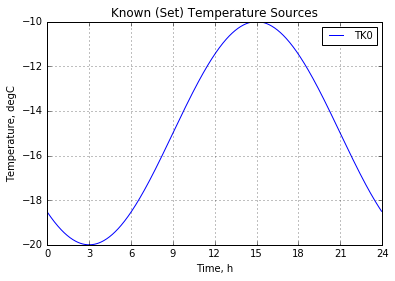

In [7]:
# Plot known temperature sources
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plotTK = TK[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTK)
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.grid()
#plt.ylim([-20,-5])
labels = ['TK' + str(n) for n in range(nM)]
plt.legend(labels,loc='best', fontsize='medium')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Known (Set) Temperature Sources')

#### Heat Sources

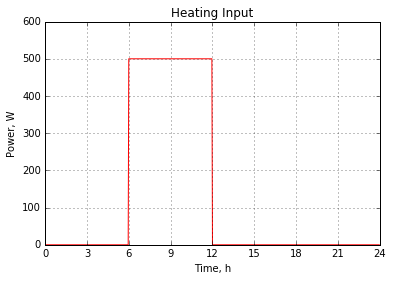

In [8]:
# Assuming there's a pulse of 500 W of heat for 6 hours a day
q_in = np.concatenate( (np.zeros(nt*1/4), 500*np.ones(nt/4), np.zeros(nt*2/4)) , axis=0)

# Plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(np.dot(dt/3600.,range(0,nt)),q_in,'r')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.ylim([0,600])
plt.grid()
#plt.legend(['Heating Input'], loc='best', fontsize='medium')
plt.xlabel('Time, h')
plt.ylabel('Power, W')
plt.title('Heating Input')

#### Initial Conditions

In [9]:
T[0,] = 10.      # all temperatures set to 10 degC

------------
## Run Simulation (Implicit Scheme)
Ideally, we should be able to reuse this part of the code applying only minimal changes. For cases where materials properties change over time or due to temperature, or when controls are present, the U-matrix completion should be done within the Main Loop.

### U-matrix completion

In [13]:
# Here, we complete the connections due to symmetry (?): 
# Node 0 is connected to node 1; also, node 1 is connected to node 0.
U = -Uin - Uin.T  # U is symmetrical, non-diagonals are -ve
s = -np.sum(U,1)
for i in range(0,nN):
    U[i,i] = s[i] + np.sum(F[i,]) + C[i]/dt
del s

### Main Loop

In [14]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node, external sources
        Qin = np.zeros((nN,1))
        Qin[1] = q_in[t]

        # Q-vector: Q = Qin + F*TM(t) + C/dt*T(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1)) + \
        np.multiply(C/dt, np.reshape(T[d*nt+t,:],(nN,1)))

        # Compute temperature
        # This is where the magic happens. For a system where nothing changes 
        # (no controls, no moveable blinds, no PCM; we need only define the 
        # U-matrix once (done above) and use it here)
        if (days*nt) > (d*nt+t+1):
            T[d*nt+t+1,] = np.linalg.solve(U,Q).T

## Plotting

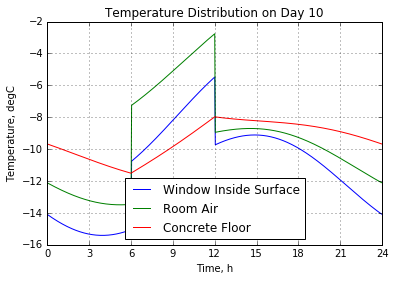

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.hold(True)
plotT = T[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Window Inside Surface','Room Air','Concrete Floor'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()

------------
## Run Simulation (Explicit Scheme)

In [ ]:
# Declare variables
Te = np.zeros((nt*days,nN))  # degC, temperatures for explicit mode
Te[0,] = T[0,]               # initial condition set to be the same as implicit case

# RHS matrix
Ue = Uin + Uin.T
s = -np.sum(Ue,1)
for i in range(0,nN):
    Ue[i,i] = s[i] - np.sum(F[i,]) + C[i]/dt
del i, s
Und = Uin + Uin.T                # Without the diagonals

### Main Loop

In [ ]:
# Loop for number of days, and for all timesteps in a day
for d in range(0,days):
    for t in range(0,nt):
        
        # Heat flow into the node
        Qin = np.zeros((nN,1))
        Qin[1] = q_in[t]

        # Q-vector (explicit): Q = Qin + F*TM(t)
        Q = Qin + np.reshape(np.dot(F, TK[d*nt+t,]),(nN,1))

        # Compute temperature
        # This is where the magic happens. Prepare to be amazed!
        if (days*nt) > (d*nt+t+1):
            for c in range(nN):
                
                # Nodes with capacitance (diffusion nodes)
                if (C[c] != 0.):
                    Te[d*nt+t+1,c] = dt/C[c] * (np.dot(Ue[c,],Te[d*nt+t,]) + Q[c])
                
                # Nodes without capacitance (arithmetic nodes)
                else:
                    Te[d*nt+t+1,c] = (np.dot(Und[c,],Te[d*nt+t,]) + np.dot(F[c,],TK[d*nt+t,]) + Qin[c]) \
                                     / (np.sum(Und[c,]) + np.sum(F[c,]))

### Plotting

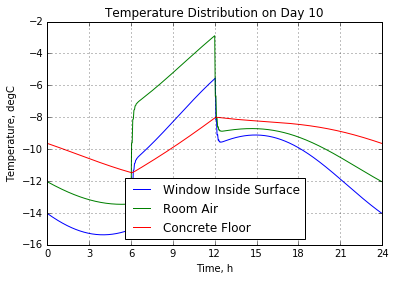

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plotTe = Te[(days-1)*nt:(days)*nt:]
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTe)
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Window Inside Surface','Room Air','Concrete Floor'],loc='best')
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Temperature Distribution on Day %s' %(days))
plt.grid()
plt.show()

----------
## Comparative Plot
Let's compare the Implicit and Explicit schemes. Play with the "steps per hour" term *st* and see its effect on the temperature profiles.

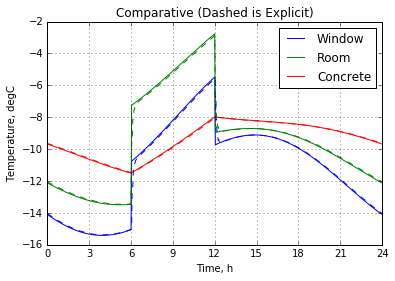

Chosen timestep: 2.50 minutes


In [20]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(np.dot(dt/3600.,range(0,nt)),plotT)
plt.gca().set_prop_cycle(None)          # restart colouring order
plt.plot(np.dot(dt/3600.,range(0,nt)),plotTe,'--')
plt.xlim([0,24])
ax.set_xticks(np.arange(0,25,3))
plt.legend(['Window','Room','Concrete'],loc=1)
plt.xlabel('Time, h')
plt.ylabel('Temperature, degC')
plt.title('Comparative (Dashed is Explicit)')
plt.grid()
plt.show()

print "Chosen timestep: %.2f minutes" % (60./st)